## Imports

In [ ]:
import numpy as np
import time
from typing import Tuple, Dict, List

import matplotlib.pyplot as plt
%matplotlib inline

from keras import datasets as dt
from sklearn.decomposition import FastICA
from skimage import data, color, img_as_float
from skimage.io import imread
from skimage.transform import resize

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11

np.random.seed(42)

## Helper Functions

### Image Preprocessing

In [ ]:
def to_grayscale_float(img):
    """Convert image to grayscale float in [0,1]."""
    img = img_as_float(img)
    if img.ndim == 3 and img.shape[2] == 3:
        img = color.rgb2gray(img)
    return img


def preprocess_images(img1, img2):
    """Convert to grayscale and resize to match dimensions."""
    s1 = to_grayscale_float(img1)
    s2 = to_grayscale_float(img2)
    if s1.shape != s2.shape:
        s2 = resize(s2, s1.shape, anti_aliasing=True)
    return s1, s2

### Signal Processing

In [ ]:
def zero_mean_unit_var(x):
    """Normalize to zero mean and unit variance (needed for ICA)."""
    x = x.astype(np.float64)
    x = x - x.mean()
    var = x.var()
    if var == 0:
        return x
    return x / np.sqrt(var)


def add_noise(Y, scale=0.25):
    """Add Gaussian noise to image, clip to [0,1]."""
    E = np.random.normal(loc=0, scale=scale, size=Y.shape)
    return np.clip(Y + E, 0, 1)

### Evaluation Metrics

In [ ]:
def snr_db(s_true, s_est):
    """SNR in decibels. Higher = better reconstruction."""
    signal_power = np.mean(s_true ** 2)
    noise_power = np.mean((s_true - s_est) ** 2) + 1e-12
    return 10.0 * np.log10(signal_power / noise_power)


def kl_divergence(p, q, epsilon=1e-10):
    """KL divergence D_KL(p || q)."""
    p = p + epsilon
    q = q + epsilon
    p = p / np.sum(p)
    q = q / np.sum(q)
    return np.sum(p * np.log(p / q))


def best_scale(a, b):
    """Find alpha that minimizes ||a - alpha*b||^2."""
    return float(np.dot(a, b) / (np.dot(b, b) + 1e-12))


def resolve_permutation_and_scaling(s1, s2, y1, y2):
    """
    ICA only recovers sources up to permutation and scaling.
    Test both orderings and pick the one with higher total SNR.
    """
    # Try y1->s1, y2->s2
    alpha_11 = best_scale(s1, y1)
    snr11 = snr_db(s1, alpha_11 * y1)
    alpha_22 = best_scale(s2, y2)
    snr22 = snr_db(s2, alpha_22 * y2)
    sum_direct = snr11 + snr22

    # Try y1->s2, y2->s1
    alpha_12 = best_scale(s1, y2)
    snr12 = snr_db(s1, alpha_12 * y2)
    alpha_21 = best_scale(s2, y1)
    snr21 = snr_db(s2, alpha_21 * y1)
    sum_swap = snr12 + snr21

    if sum_swap > sum_direct:
        return snr12, snr21, alpha_12 * y2, alpha_21 * y1
    else:
        return snr11, snr22, alpha_11 * y1, alpha_22 * y2

### EASI Score Functions

In [ ]:
def easi_score_function(y):
    """
    Nonlinear score function g(y) for EASI.
    Using tan + y^2 for heavy-tailed, sin + y for sub-Gaussian.
    """
    y1, y2 = y[0], y[1]
    # Clip to avoid blowing up near tan singularities
    y1_clip = np.clip(y1, -1.4, 1.4)
    y2_clip = np.clip(y2, -3, 3)
    return np.array([np.tan(y1_clip) + y1**2, np.sin(y2_clip) + y2], dtype=np.float64)


def tanh_score_function(y):
    """Simple tanh score (like FastICA uses)."""
    return np.tanh(y)


def compute_easi_loss(B, X, N, num_samples=1000):
    """
    EASI loss = decorrelation loss + log-det regularizer.
    Returns (total, decorr, det).
    """
    sample_indices = np.random.choice(N, min(num_samples, N), replace=False)
    Y_samples = B @ X[:, sample_indices]

    # Want covariance to be identity
    cov_matrix = (Y_samples @ Y_samples.T) / Y_samples.shape[1]
    decorrelation_loss = np.linalg.norm(cov_matrix - np.eye(2), 'fro') ** 2

    # Prevent B from becoming singular
    det_B = np.linalg.det(B)
    log_det_loss = -np.log(np.abs(det_B) + 1e-10)

    total_loss = decorrelation_loss + 0.1 * log_det_loss
    return total_loss, decorrelation_loss, log_det_loss

### Training Functions

In [ ]:
def train_easi_sgd(X, learning_rate=1e-4, iterations=50000, loss_interval=100, verbose=True):
    """
    EASI with vanilla SGD.
    Update: B = B - lr * (yy^T - I + g(y)y^T - yg(y)^T) @ B
    """
    N = X.shape[1]
    B = np.eye(2)
    loss_history = []

    if verbose:
        print(f"EASI-SGD: lr={learning_rate}, iters={iterations:,}")

    for k in range(iterations):
        idx = k % N
        x_sample = X[:, idx]
        y = B @ x_sample

        Y_outer = np.outer(y, y)
        G = easi_score_function(y).reshape(2, 1)
        term = Y_outer - np.eye(2) + (G @ y.reshape(1, 2)) - (y.reshape(2, 1) @ G.T)

        B = B - learning_rate * (term @ B)

        if k % loss_interval == 0:
            total_loss, decorr_loss, det_loss = compute_easi_loss(B, X, N)
            loss_history.append({
                'iteration': k,
                'total_loss': total_loss,
                'decorrelation_loss': decorr_loss,
                'log_det_loss': det_loss
            })
            if verbose and k % 10000 == 0:
                print(f"  iter {k:6,}: loss={total_loss:.6f}")

    if verbose:
        print("  Done.")
    return B, loss_history


def train_easi_adam(X, learning_rate=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8,
                    iterations=50000, loss_interval=100, verbose=True):
    """EASI with Adam optimizer."""
    N = X.shape[1]
    B = np.eye(2)
    m = np.zeros_like(B)
    v = np.zeros_like(B)
    loss_history = []

    if verbose:
        print(f"EASI-Adam: lr={learning_rate}, beta1={beta1}, beta2={beta2}")

    for k in range(iterations):
        idx = k % N
        x_sample = X[:, idx]
        y = B @ x_sample

        Y_outer = np.outer(y, y)
        G_score = easi_score_function(y).reshape(2, 1)
        term = Y_outer - np.eye(2) + (G_score @ y.reshape(1, 2)) - (y.reshape(2, 1) @ G_score.T)
        grad = term @ B

        # Adam updates
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        m_hat = m / (1 - beta1 ** (k + 1))
        v_hat = v / (1 - beta2 ** (k + 1))
        B = B - learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        if k % loss_interval == 0:
            total_loss, decorr_loss, det_loss = compute_easi_loss(B, X, N)
            loss_history.append({
                'iteration': k,
                'total_loss': total_loss,
                'decorrelation_loss': decorr_loss,
                'log_det_loss': det_loss
            })
            if verbose and k % 10000 == 0:
                print(f"  iter {k:6,}: loss={total_loss:.6f}")

    if verbose:
        print("  Done.")
    return B, loss_history

### Visualization

In [ ]:
def display_images(images, titles, figsize=(12, 5), cmap='gray'):
    """Show images side by side."""
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    if len(images) == 1:
        axes = [axes]

    for ax, img, title in zip(axes, images, titles):
        im = ax.imshow(img, cmap=cmap)
        ax.set_title(f'{title}\nShape: {img.shape} | Range: [{img.min():.3f}, {img.max():.3f}]')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)
    plt.tight_layout()
    plt.show()


def plot_histogram_with_pdf(x, num_bins=100, title_prefix="s"):
    """Plot histogram and estimated PDF."""
    x = x.flatten()
    N = len(x)
    hist, bin_edges = np.histogram(x, bins=num_bins)
    delta = (bin_edges[-1] - bin_edges[0]) / num_bins
    pdf = hist / (N * delta)
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    axes[0].bar(centers, hist, width=delta)
    axes[0].set_xlabel(title_prefix)
    axes[0].set_ylabel("Count")
    axes[0].set_title(f"Histogram of {title_prefix}")

    axes[1].plot(centers, pdf)
    axes[1].set_xlabel(title_prefix)
    axes[1].set_ylabel("Density")
    axes[1].set_title(f"Estimated PDF of {title_prefix}")
    plt.tight_layout()
    plt.show()


def plot_pdf_comparison(original, recovered, num_bins=100, title_prefix="s"):
    """Compare PDFs of original vs recovered, return KL divergence."""
    orig = original.flatten()
    rec = recovered.flatten()
    N = len(orig)

    bin_min = min(orig.min(), rec.min())
    bin_max = max(orig.max(), rec.max())
    bin_edges = np.linspace(bin_min, bin_max, num_bins + 1)
    delta = (bin_max - bin_min) / num_bins
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    hist_orig, _ = np.histogram(orig, bins=bin_edges)
    hist_rec, _ = np.histogram(rec, bins=bin_edges)

    pdf_orig = hist_orig / (N * delta)
    pdf_rec = hist_rec / (N * delta)
    kl_div = kl_divergence(hist_orig, hist_rec)

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    width = delta * 0.4
    axes[0].bar(centers - width/2, hist_orig, width=width, alpha=0.7, label='Original', color='blue')
    axes[0].bar(centers + width/2, hist_rec, width=width, alpha=0.7, label='Recovered', color='red')
    axes[0].set_xlabel(title_prefix)
    axes[0].set_ylabel("Count")
    axes[0].set_title("Histogram Comparison")
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    axes[1].plot(centers, pdf_orig, linewidth=2, label='Original PDF', color='blue')
    axes[1].plot(centers, pdf_rec, linewidth=2, label='Recovered PDF', color='red', linestyle='--')
    axes[1].set_xlabel(title_prefix)
    axes[1].set_ylabel("Density")
    axes[1].set_title(f"PDF Comparison (KL Divergence = {kl_div:.4f})")
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    return kl_div


def plot_scatter(x1, x2, title, xlabel, ylabel):
    """Scatter plot to visualize independence (rectangular = independent)."""
    plt.figure(figsize=(6, 6))
    plt.scatter(x1.flatten(), x2.flatten(), s=2, alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


def plot_scatter_comparison(s1, s2, x1, x2, y1, y2):
    """Side-by-side: original -> mixed -> recovered."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].scatter(s1.flatten(), s2.flatten(), s=2, alpha=0.5, color='blue')
    axes[0].set_xlabel('$s_1$', fontsize=11)
    axes[0].set_ylabel('$s_2$', fontsize=11)
    axes[0].set_title('Original Sources\n(Rectangular = Independent)', fontsize=12)
    axes[0].axis('equal')
    axes[0].grid(alpha=0.3)

    axes[1].scatter(x1.flatten(), x2.flatten(), s=2, alpha=0.5, color='red')
    axes[1].set_xlabel('$x_1$', fontsize=11)
    axes[1].set_ylabel('$x_2$', fontsize=11)
    axes[1].set_title('Mixed Signals\n(Elliptical = Dependent)', fontsize=12)
    axes[1].axis('equal')
    axes[1].grid(alpha=0.3)

    axes[2].scatter(y1.flatten(), y2.flatten(), s=2, alpha=0.5, color='green')
    axes[2].set_xlabel('$\\hat{s}_1$', fontsize=11)
    axes[2].set_ylabel('$\\hat{s}_2$', fontsize=11)
    axes[2].set_title('Recovered Sources\n(Rectangular = Independent)', fontsize=12)
    axes[2].axis('equal')
    axes[2].grid(alpha=0.3)

    plt.suptitle('Independence Analysis: Original -> Mixed -> Recovered', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


def plot_loss_curves(loss_history):
    """Plot training curves."""
    iterations = [entry['iteration'] for entry in loss_history]
    total_losses = [entry['total_loss'] for entry in loss_history]
    decorr_losses = [entry['decorrelation_loss'] for entry in loss_history]
    det_losses = [entry['log_det_loss'] for entry in loss_history]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    axes[0, 0].plot(iterations, total_losses, 'b-', linewidth=2)
    axes[0, 0].set_xlabel('Iteration')
    axes[0, 0].set_ylabel('Total Loss')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].grid(alpha=0.3)
    axes[0, 0].set_yscale('log')

    axes[0, 1].plot(iterations, decorr_losses, 'r-', linewidth=2)
    axes[0, 1].set_xlabel('Iteration')
    axes[0, 1].set_ylabel('Decorrelation Loss')
    axes[0, 1].set_title('Decorrelation Loss: $||E[yy^T] - I||^2$')
    axes[0, 1].grid(alpha=0.3)
    axes[0, 1].set_yscale('log')

    axes[1, 0].plot(iterations, det_losses, 'g-', linewidth=2)
    axes[1, 0].set_xlabel('Iteration')
    axes[1, 0].set_ylabel('Log Det Loss')
    axes[1, 0].set_title('Log Determinant Loss: $-\\log|\\det(B)|$')
    axes[1, 0].grid(alpha=0.3)

    axes[1, 1].plot(iterations, np.array(total_losses) / total_losses[0],
                    'b-', linewidth=2, label='Total Loss', alpha=0.7)
    axes[1, 1].plot(iterations, np.array(decorr_losses) / decorr_losses[0],
                    'r-', linewidth=2, label='Decorrelation', alpha=0.7)
    axes[1, 1].set_xlabel('Iteration')
    axes[1, 1].set_ylabel('Normalized Loss')
    axes[1, 1].set_title('Normalized Loss Convergence')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    axes[1, 1].set_yscale('log')

    plt.suptitle('EASI Training Loss Curves', fontsize=14, y=1.01)
    plt.tight_layout()
    plt.show()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


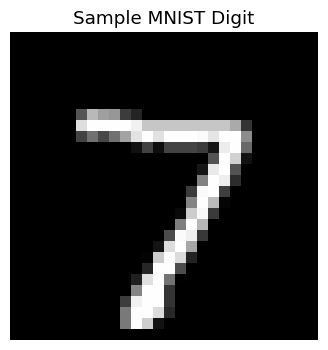

In [ ]:
# Load MNIST dataset
(train_data, train_labels), (test_data, _) = dt.mnist.load_data()

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Display a sample digit
plt.figure(figsize=(4, 4))
plt.imshow(test_data[0], cmap='gray')
plt.title('Sample MNIST Digit')
plt.axis('off')
plt.show()

In [ ]:
# Select two different digits as source images
img1 = test_data[0, :, :]  # First source (digit 7)
img2 = test_data[4, :, :]  # Second source (digit 4).

# Preprocess images
s1_img, s2_img = preprocess_images(img1, img2)
H, W = s1_img.shape

print(f"Image dimensions: {H} x {W}")
print(f"Total pixels (N): {H * W}")

Image dimensions: 28 x 28
Total pixels (N): 784


### 3.1 Normalize Sources.

We flatten and normalize the source images to satisfy the EASI algorithm's assumption of zero-mean, unit-variance signals.

Source matrix shape: (2, 784)
s1 - Mean: -0.000000, Variance: 1.000000
s2 - Mean: -0.000000, Variance: 1.000000


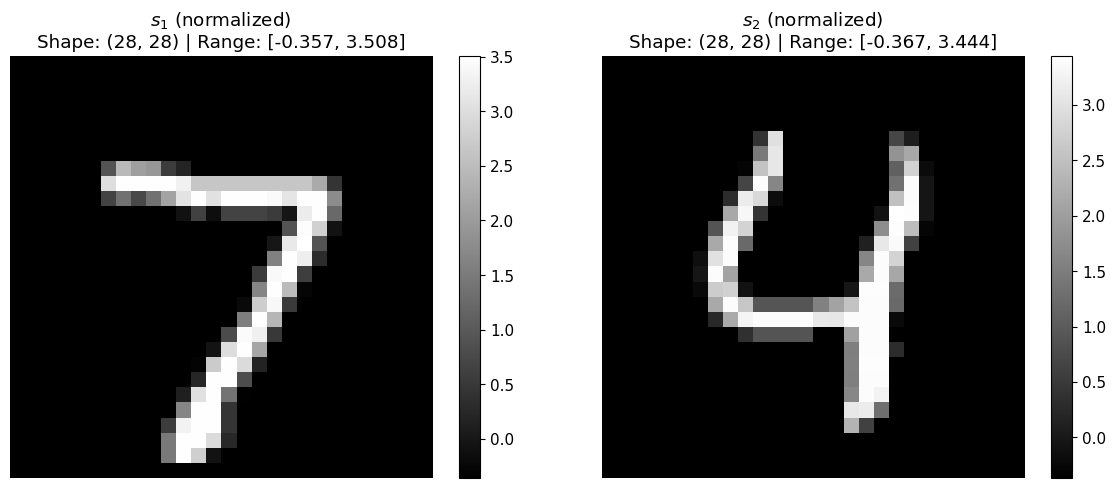

In [ ]:
# Flatten images to 1D signals.
s1 = s1_img.ravel().astype(np.float64)
s2 = s2_img.ravel().astype(np.float64)

# Normalize to zero mean and unit variance
s1 = zero_mean_unit_var(s1)
s2 = zero_mean_unit_var(s2)

# Stack as source matrix S (2 x N)
S = np.vstack([s1, s2])
N = S.shape[1]

print(f"Source matrix shape: {S.shape}")
print(f"s1 - Mean: {s1.mean():.6f}, Variance: {s1.var():.6f}")
print(f"s2 - Mean: {s2.mean():.6f}, Variance: {s2.var():.6f}")

# Display normalized source images
s1_disp = s1.reshape(H, W)
s2_disp = s2.reshape(H, W)
display_images([s1_disp, s2_disp], ['$s_1$ (normalized)', '$s_2$ (normalized)'])

### 3.2 Source Distribution Analysis.

We examine the histograms and PDFs of the original sources to understand their statistical properties.

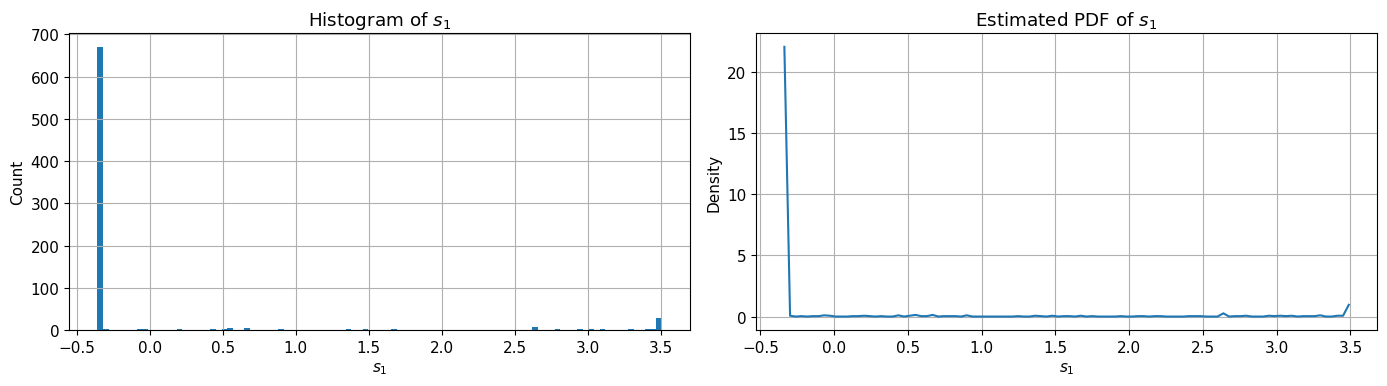

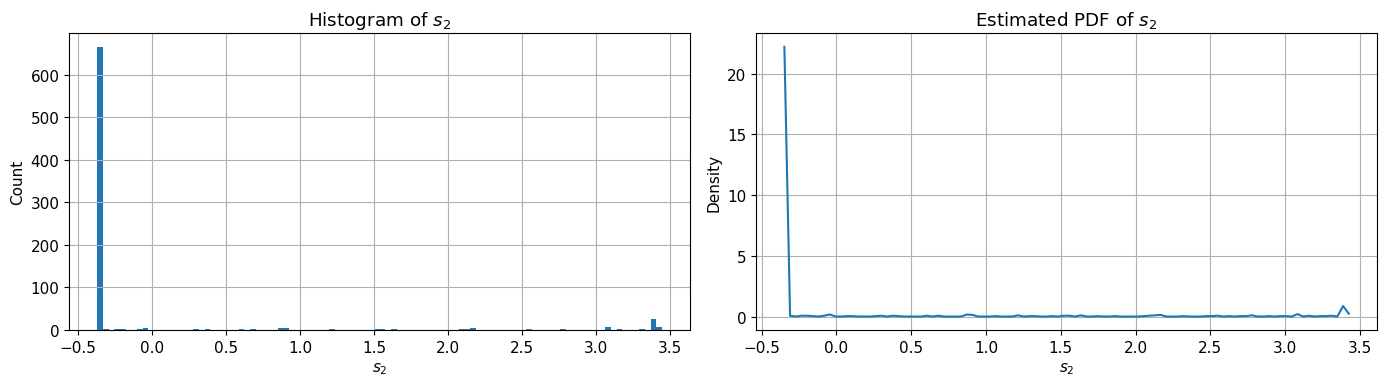

In [ ]:
plot_histogram_with_pdf(s1, num_bins=100, title_prefix="$s_1$")
plot_histogram_with_pdf(s2, num_bins=100, title_prefix="$s_2$")

### 3.3 Independence Verification.

We verify that the original sources are empirically independent by examining the scatter plot.

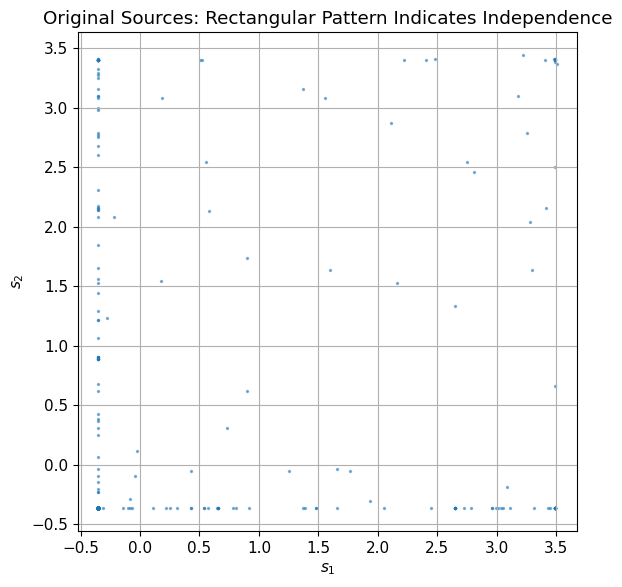

In [ ]:
plot_scatter(s1, s2,
             title="Original Sources: Rectangular Pattern Indicates Independence",
             xlabel="$s_1$", ylabel="$s_2$")

---
## 4. Linear Mixing.

We create the observed mixtures using a known mixing matrix:

$$\mathbf{X} = \mathbf{A} \mathbf{S} = \begin{bmatrix} 0.8 & 0.6 \\ 0.6 & 0.8 \end{bmatrix} \begin{bmatrix} s_1 \\ s_2 \end{bmatrix}$$

Mixing Matrix A:
[[0.8 0.6]
 [0.6 0.8]]

Condition number: 7.0000
Determinant: 0.2800


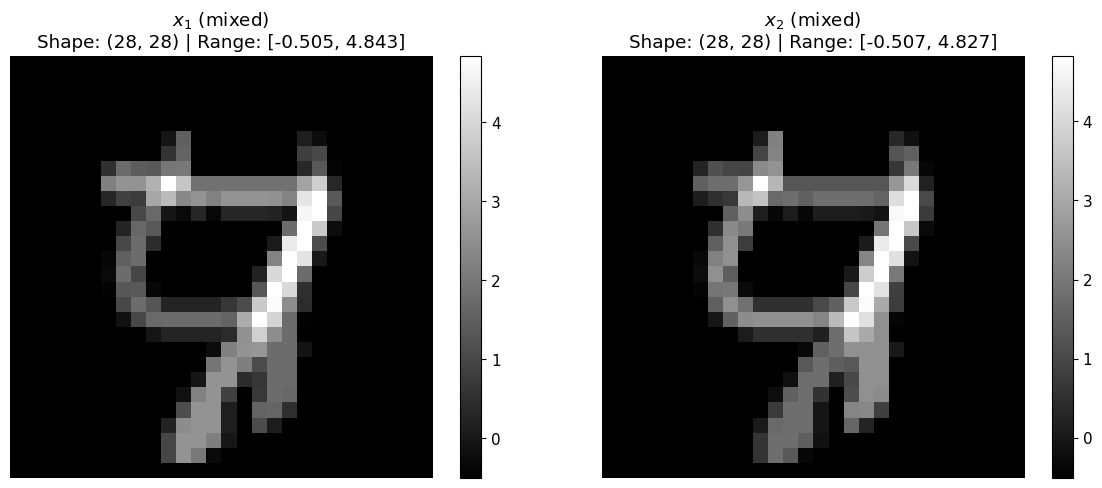

In [ ]:
# Define the mixing matrix.
A = np.array([[0.8, 0.6],
              [0.6, 0.8]], dtype=np.float64)

print("Mixing Matrix A:")
print(A)
print(f"\nCondition number: {np.linalg.cond(A):.4f}")
print(f"Determinant: {np.linalg.det(A):.4f}")

# Create mixed signals
X = A @ S
x1, x2 = X[0, :], X[1, :]

# Reshape for visualization
x1_img = x1.reshape(H, W)
x2_img = x2.reshape(H, W)

# Display mixed images
display_images([x1_img, x2_img], ['$x_1$ (mixed)', '$x_2$ (mixed)'])

### 4.1 Mixed Signal Analysis.

We analyze the distributions of the mixed signals and verify that they are now correlated.

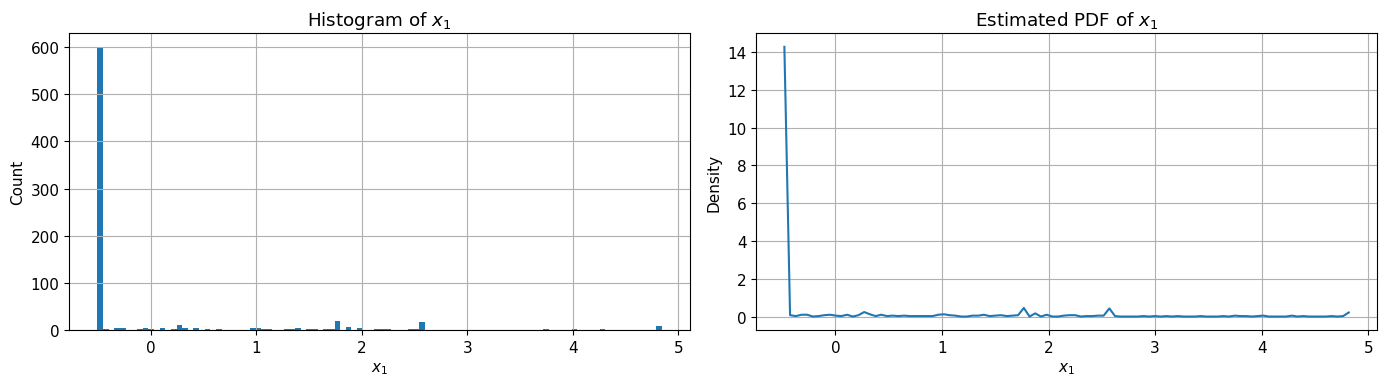

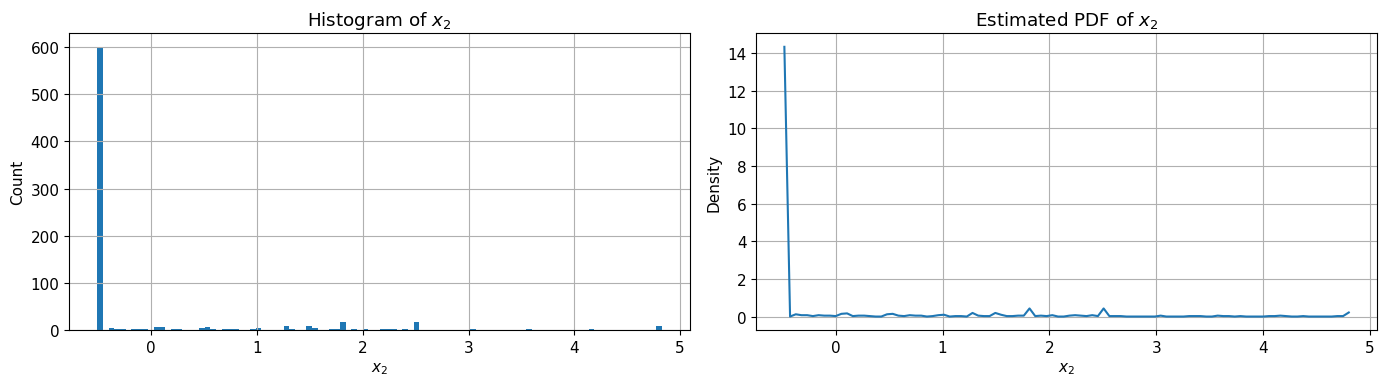

In [ ]:
# Histogram and PDF of mixed signals.
plot_histogram_with_pdf(x1, num_bins=100, title_prefix="$x_1$")
plot_histogram_with_pdf(x2, num_bins=100, title_prefix="$x_2$")

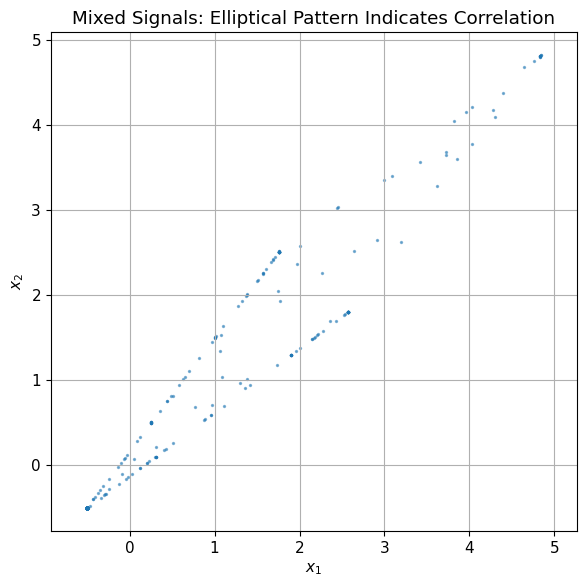

In [ ]:
# Scatter plot shows correlation introduced by mixing.
plot_scatter(x1, x2,
             title="Mixed Signals: Elliptical Pattern Indicates Correlation",
             xlabel="$x_1$", ylabel="$x_2$")

---
## 5. EASI Algorithm Implementation and Training.

### 5.1 EASI Algorithm Theory

The EASI (Equivariant Adaptive Separation via Independence) algorithm performs online updates to learn the demixing matrix $\mathbf{B}$. The update rule is:

$$B_{k+1} = B_k - \mu \Big( yy^\top - I + g(y)y^\top - yg(y)^\top \Big) B_k$$

where:
- $y = B_k x$ is the current separated output
- $g(y)$ is a nonlinear score function
- $\mu$ is the learning rate
- The term $(yy^\top - I)$ enforces decorrelation
- The term $(g(y)y^\top - yg(y)^\top)$ enforces statistical independence

### 5.2 Train EASI with SGD.

In [ ]:
# Training parameters
SGD_LR = 1e-4
ITERATIONS = 50000

# Train EASI-SGD
print("=" * 60)
print("EASI-SGD Training")
print("=" * 60)

start_time = time.time()
B_sgd, loss_history_sgd = train_easi_sgd(
    X,
    learning_rate=SGD_LR,
    iterations=ITERATIONS,
    loss_interval=100,
    verbose=True
)
sgd_time = time.time() - start_time

print(f"\nTraining time: {sgd_time:.2f} seconds")

# Perform final separation
Y_sgd = B_sgd @ X
y1_sgd, y2_sgd = Y_sgd[0, :], Y_sgd[1, :]

# Resolve permutation and scaling ambiguity
SNR1_sgd, SNR2_sgd, y1_aligned_sgd, y2_aligned_sgd = resolve_permutation_and_scaling(
    s1, s2, y1_sgd, y2_sgd
)

print(f"\nEASI-SGD Results:")
print(f"  Source 1 SNR: {SNR1_sgd:.2f} dB")
print(f"  Source 2 SNR: {SNR2_sgd:.2f} dB")
print(f"  Average SNR:  {(SNR1_sgd + SNR2_sgd) / 2:.2f} dB")

EASI-SGD Training
Training EASI-SGD: lr=0.0001, iterations=50,000
  Iteration      0: Loss=3.269469, Decorr=3.269484
  Iteration 10,000: Loss=0.631153, Decorr=0.679765
  Iteration 20,000: Loss=0.038249, Decorr=0.146119
  Iteration 30,000: Loss=-0.125175, Decorr=0.004736
  Iteration 40,000: Loss=-0.130241, Decorr=0.000427
  Training complete.

Training time: 2.56 seconds

EASI-SGD Results:
  Source 1 SNR: 12.53 dB
  Source 2 SNR: 25.35 dB
  Average SNR:  18.94 dB


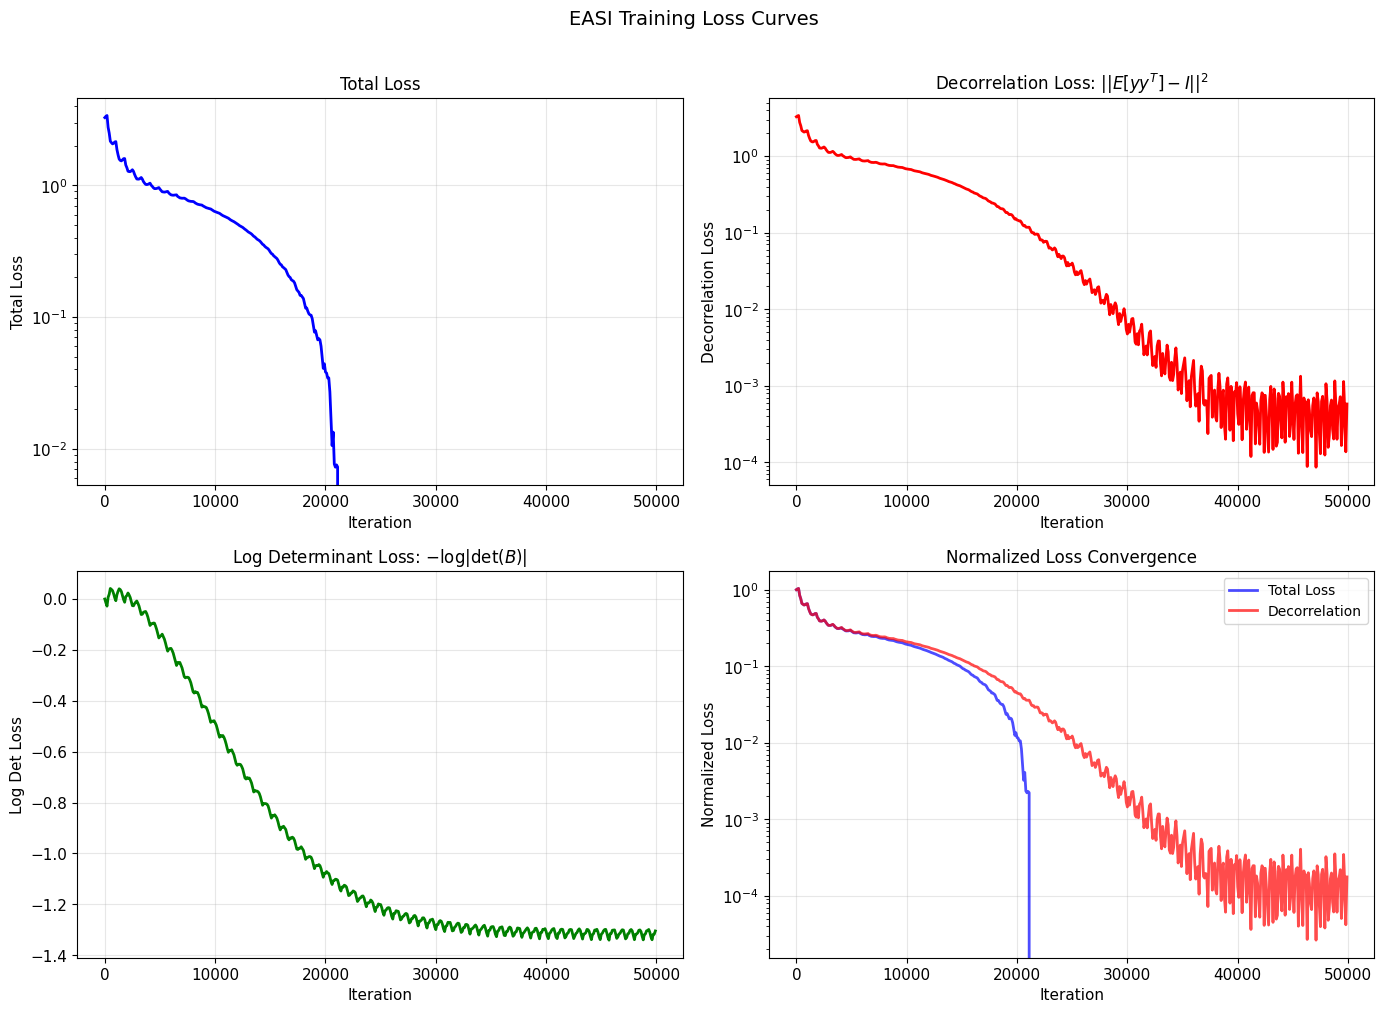

In [ ]:
# Plot SGD loss curves.
plot_loss_curves(loss_history_sgd)

### 5.3 Train EASI with Adam Optimizer.

In [ ]:
# Adam hyperparameters.
ADAM_LR = 1e-3
BETA1 = 0.9
BETA2 = 0.999

# Train EASI-Adam
print("=" * 60)
print("EASI-Adam Training")
print("=" * 60)

start_time = time.time()
B_adam, loss_history_adam = train_easi_adam(
    X,
    learning_rate=ADAM_LR,
    beta1=BETA1,
    beta2=BETA2,
    iterations=ITERATIONS,
    loss_interval=100,
    verbose=True
)
adam_time = time.time() - start_time

print(f"\nTraining time: {adam_time:.2f} seconds")

# Perform final separation
Y_adam = B_adam @ X
y1_adam, y2_adam = Y_adam[0, :], Y_adam[1, :]

# Resolve permutation and scaling ambiguity
SNR1_adam, SNR2_adam, y1_aligned_adam, y2_aligned_adam = resolve_permutation_and_scaling(
    s1, s2, y1_adam, y2_adam
)

print(f"\nEASI-Adam Results:")
print(f"  Source 1 SNR: {SNR1_adam:.2f} dB")
print(f"  Source 2 SNR: {SNR2_adam:.2f} dB")
print(f"  Average SNR:  {(SNR1_adam + SNR2_adam) / 2:.2f} dB")

EASI-Adam Training
Training EASI-Adam: lr=0.001, beta1=0.9, beta2=0.999
  Iteration      0: Loss=3.283873, Decorr=3.284073
  Iteration 10,000: Loss=0.175408, Decorr=0.281308
  Iteration 20,000: Loss=0.038683, Decorr=0.175447
  Iteration 30,000: Loss=-0.098568, Decorr=0.038448
  Iteration 40,000: Loss=-0.129849, Decorr=0.003787
  Training complete.

Training time: 3.15 seconds

EASI-Adam Results:
  Source 1 SNR: 5.54 dB
  Source 2 SNR: 11.40 dB
  Average SNR:  8.47 dB


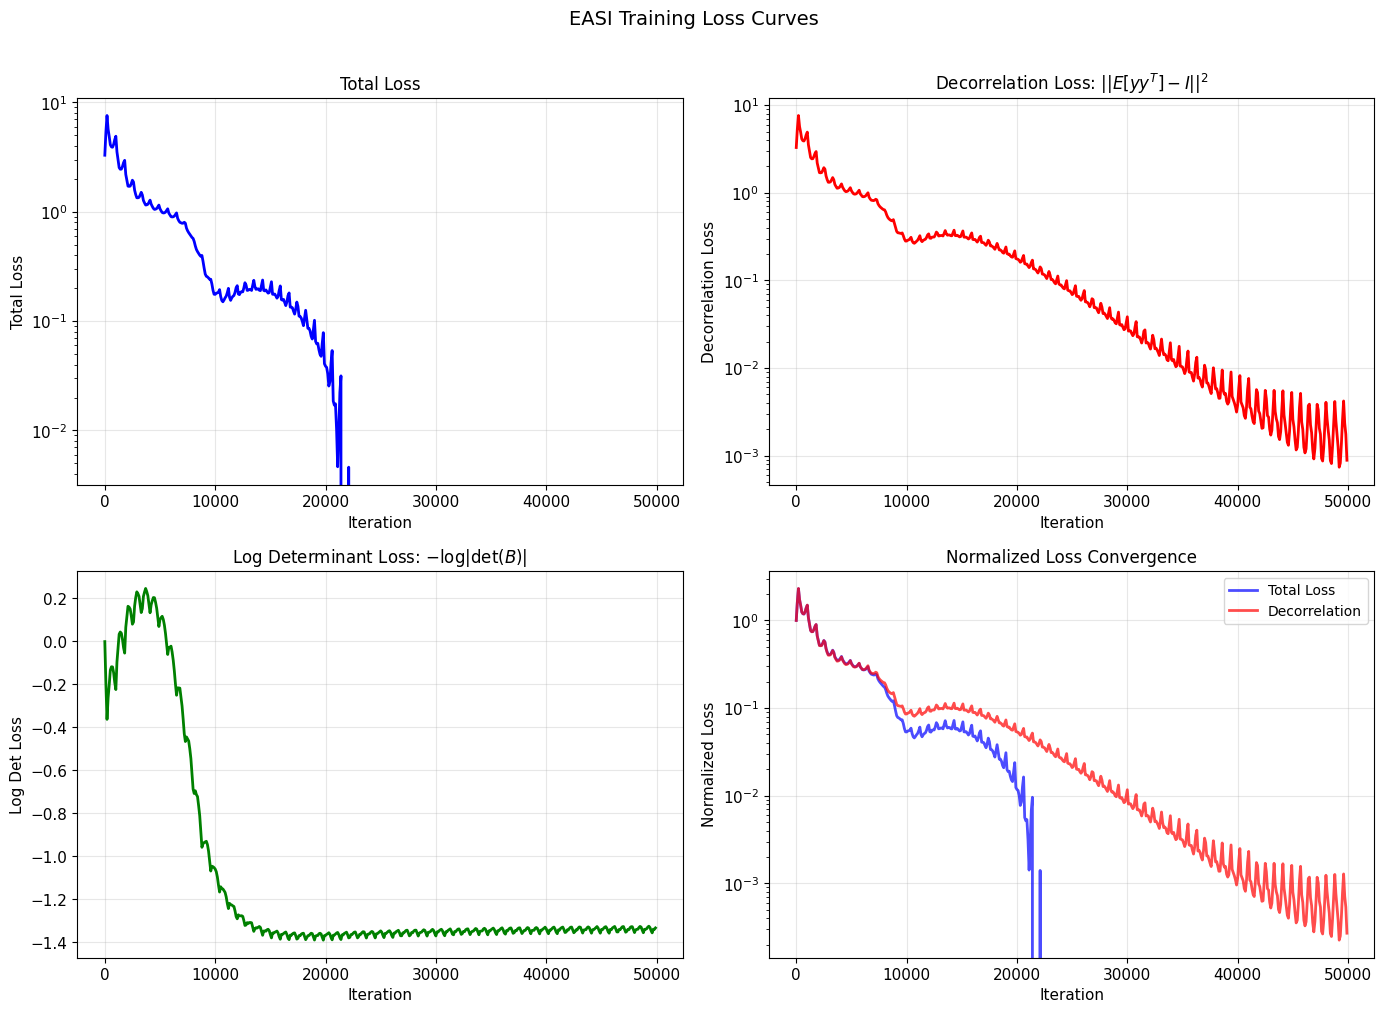

In [ ]:
# Plot Adam loss curves.
plot_loss_curves(loss_history_adam)

### 5.4 FastICA Baseline.

We compare the online EASI methods with the batch FastICA algorithm as a baseline.

In [ ]:
print("=" * 60)
print("FastICA Baseline")
print("=" * 60)

start_time = time.time()
ica = FastICA(n_components=2, max_iter=200, random_state=42)
Y_ica = ica.fit_transform(X.T).T
ica_time = time.time() - start_time

y1_ica, y2_ica = Y_ica[0, :], Y_ica[1, :]

# Resolve permutation and scaling.
SNR1_ica, SNR2_ica, y1_aligned_ica, y2_aligned_ica = resolve_permutation_and_scaling(
    s1, s2, y1_ica, y2_ica
)

print(f"Training time: {ica_time:.2f} seconds")
print(f"\nFastICA Results:")
print(f"  Source 1 SNR: {SNR1_ica:.2f} dB")
print(f"  Source 2 SNR: {SNR2_ica:.2f} dB")
print(f"  Average SNR:  {(SNR1_ica + SNR2_ica) / 2:.2f} dB")

FastICA Baseline
Training time: 0.02 seconds

FastICA Results:
  Source 1 SNR: 11.86 dB
  Source 2 SNR: 29.33 dB
  Average SNR:  20.60 dB


---
## 6. Results and Evaluation.

---
We conduct a controlled comparison of all three methods (FastICA, EASI-SGD, EASI-Adam) at 10,000 iterations to fairly evaluate convergence behavior and separation quality.

We conduct a controlled comparison of all three methods (FastICA, EASI-SGD, EASI-Adam) at exactly 10,000 iterations to fairly evaluate convergence behavior and separation quality.

In [ ]:
# Controlled comparison at 10,000 iterations
COMPARISON_ITERATIONS = 10000

print("=" * 70)
print("CONTROLLED COMPARISON AT 10,000 ITERATIONS")
print("=" * 70)
print(f"Iterations: {COMPARISON_ITERATIONS:,}")
print(f"EASI-SGD learning rate: {SGD_LR}")
print(f"EASI-Adam learning rate: {ADAM_LR}")
print("=" * 70)

# Reset random seed for reproducibility
np.random.seed(42)

# Train EASI-SGD at 10k iterations
print("\nTraining EASI-SGD (10k iterations)...")
start_time = time.time()
B_sgd_10k, loss_history_sgd_10k = train_easi_sgd(
    X, learning_rate=SGD_LR, iterations=COMPARISON_ITERATIONS,
    loss_interval=100, verbose=False
)
sgd_10k_time = time.time() - start_time

Y_sgd_10k = B_sgd_10k @ X
SNR1_sgd_10k, SNR2_sgd_10k, y1_sgd_10k, y2_sgd_10k = resolve_permutation_and_scaling(
    s1, s2, Y_sgd_10k[0, :], Y_sgd_10k[1, :]
)
avg_sgd_10k = (SNR1_sgd_10k + SNR2_sgd_10k) / 2
print(f"  Completed in {sgd_10k_time:.2f}s, Avg SNR: {avg_sgd_10k:.2f} dB")

# Train EASI-Adam at 10k iterations
print("\nTraining EASI-Adam (10k iterations)...")
start_time = time.time()
B_adam_10k, loss_history_adam_10k = train_easi_adam(
    X, learning_rate=ADAM_LR, iterations=COMPARISON_ITERATIONS,
    loss_interval=100, verbose=False
)
adam_10k_time = time.time() - start_time

Y_adam_10k = B_adam_10k @ X
SNR1_adam_10k, SNR2_adam_10k, y1_adam_10k, y2_adam_10k = resolve_permutation_and_scaling(
    s1, s2, Y_adam_10k[0, :], Y_adam_10k[1, :]
)
avg_adam_10k = (SNR1_adam_10k + SNR2_adam_10k) / 2
print(f"  Completed in {adam_10k_time:.2f}s, Avg SNR: {avg_adam_10k:.2f} dB")

# FastICA baseline (batch method, ~200 iterations internally)
print("\nRunning FastICA baseline...")
start_time = time.time()
ica_10k = FastICA(n_components=2, max_iter=200, random_state=42)
Y_ica_10k = ica_10k.fit_transform(X.T).T
ica_10k_time = time.time() - start_time

SNR1_ica_10k, SNR2_ica_10k, y1_ica_10k, y2_ica_10k = resolve_permutation_and_scaling(
    s1, s2, Y_ica_10k[0, :], Y_ica_10k[1, :]
)
avg_ica_10k = (SNR1_ica_10k + SNR2_ica_10k) / 2
print(f"  Completed in {ica_10k_time:.2f}s, Avg SNR: {avg_ica_10k:.2f} dB")

CONTROLLED COMPARISON AT 10,000 ITERATIONS
Iterations: 10,000
EASI-SGD learning rate: 0.0001
EASI-Adam learning rate: 0.001

Training EASI-SGD (10k iterations)...
  Completed in 0.35s, Avg SNR: 3.24 dB

Training EASI-Adam (10k iterations)...
  Completed in 0.44s, Avg SNR: 11.21 dB

Running FastICA baseline...
  Completed in 0.00s, Avg SNR: 20.60 dB


### 6.1 Visual Comparison at 10,000 Iterations.

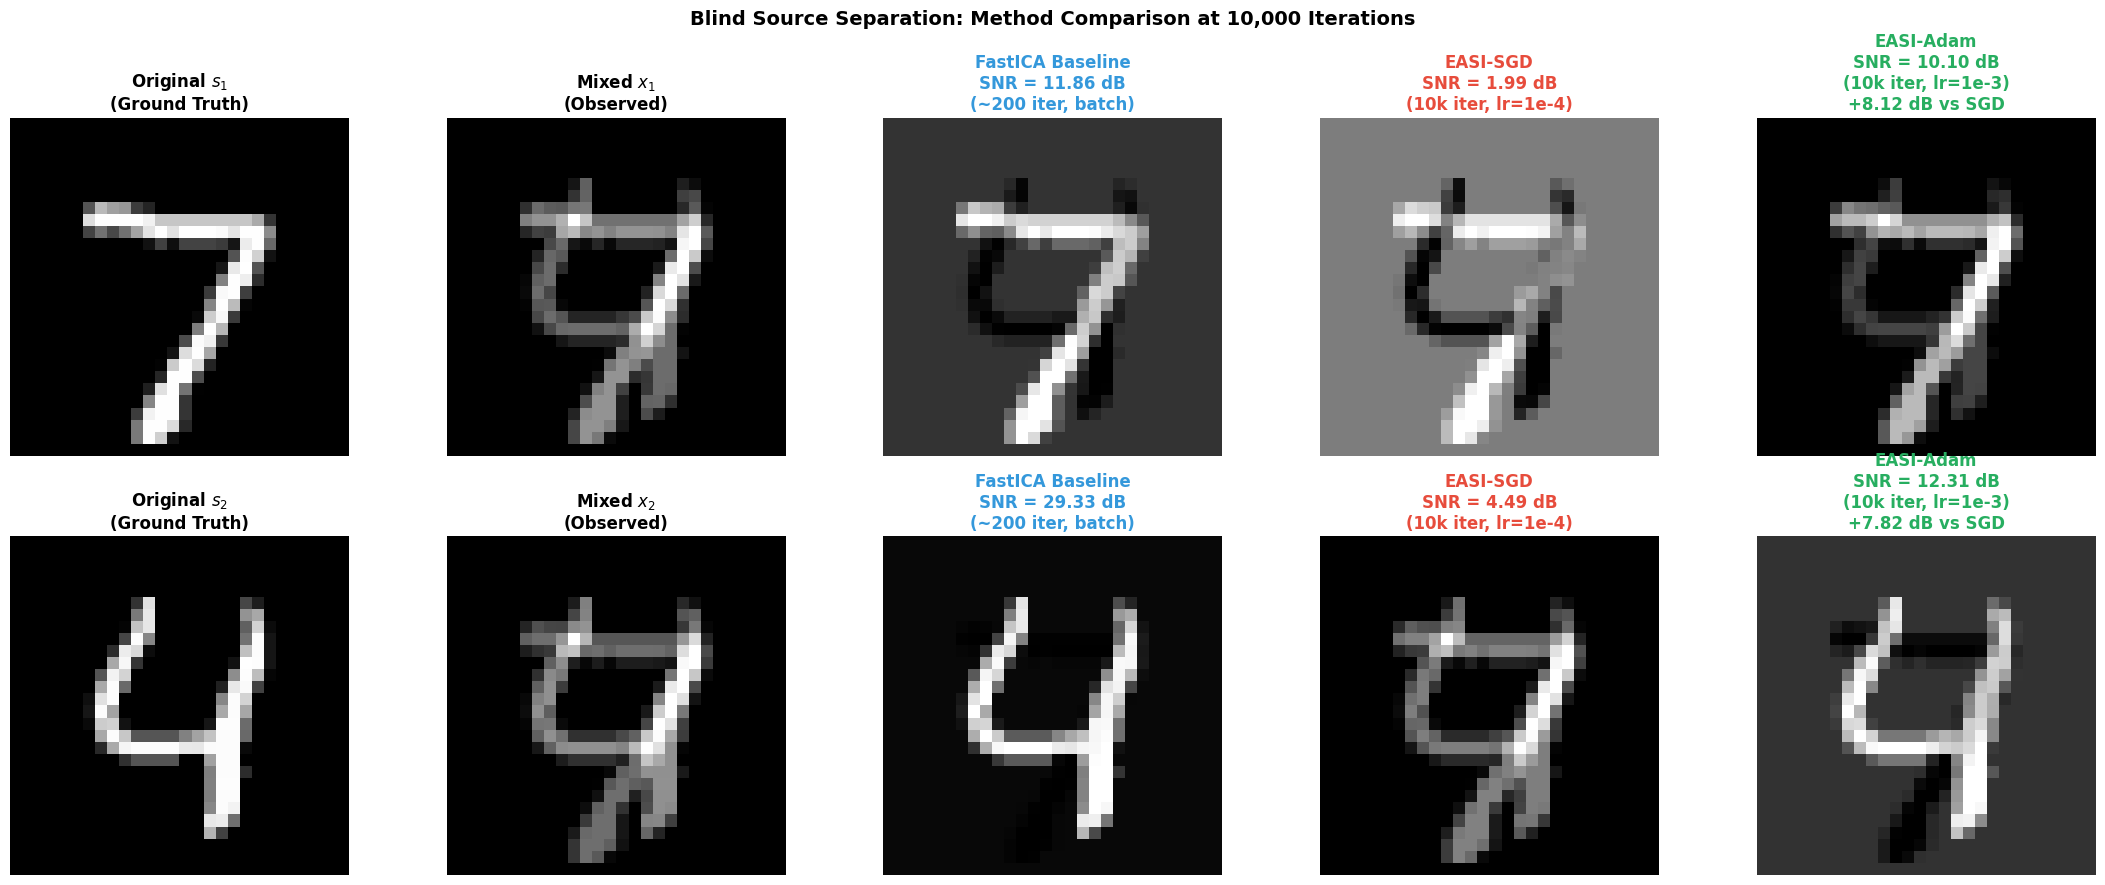

In [ ]:
# Reshape for visualization.
y1_sgd_10k_img = y1_sgd_10k.reshape(H, W)
y2_sgd_10k_img = y2_sgd_10k.reshape(H, W)
y1_adam_10k_img = y1_adam_10k.reshape(H, W)
y2_adam_10k_img = y2_adam_10k.reshape(H, W)
y1_ica_10k_img = y1_ica_10k.reshape(H, W)
y2_ica_10k_img = y2_ica_10k.reshape(H, W)

# Create comparison figure
fig, axes = plt.subplots(2, 5, figsize=(22, 9))

# Define colors for each method
color_ica = '#3498DB'
color_sgd = '#E74C3C'
color_adam = '#27AE60'

# Row 1: Source 1 pipeline
axes[0, 0].imshow(s1_disp, cmap='gray')
axes[0, 0].set_title('Original $s_1$\n(Ground Truth)', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(x1_img, cmap='gray')
axes[0, 1].set_title('Mixed $x_1$\n(Observed)', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(y1_ica_10k_img, cmap='gray')
axes[0, 2].set_title(f'FastICA Baseline\nSNR = {SNR1_ica_10k:.2f} dB\n(~200 iter, batch)',
                     fontsize=12, fontweight='bold', color=color_ica)
axes[0, 2].axis('off')

axes[0, 3].imshow(y1_sgd_10k_img, cmap='gray')
axes[0, 3].set_title(f'EASI-SGD\nSNR = {SNR1_sgd_10k:.2f} dB\n(10k iter, lr=1e-4)',
                     fontsize=12, fontweight='bold', color=color_sgd)
axes[0, 3].axis('off')

axes[0, 4].imshow(y1_adam_10k_img, cmap='gray')
improvement1 = SNR1_adam_10k - SNR1_sgd_10k
axes[0, 4].set_title(f'EASI-Adam\nSNR = {SNR1_adam_10k:.2f} dB\n(10k iter, lr=1e-3)\n+{improvement1:.2f} dB vs SGD',
                     fontsize=12, fontweight='bold', color=color_adam)
axes[0, 4].axis('off')

# Row 2: Source 2 pipeline
axes[1, 0].imshow(s2_disp, cmap='gray')
axes[1, 0].set_title('Original $s_2$\n(Ground Truth)', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(x2_img, cmap='gray')
axes[1, 1].set_title('Mixed $x_2$\n(Observed)', fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

axes[1, 2].imshow(y2_ica_10k_img, cmap='gray')
axes[1, 2].set_title(f'FastICA Baseline\nSNR = {SNR2_ica_10k:.2f} dB\n(~200 iter, batch)',
                     fontsize=12, fontweight='bold', color=color_ica)
axes[1, 2].axis('off')

axes[1, 3].imshow(y2_sgd_10k_img, cmap='gray')
axes[1, 3].set_title(f'EASI-SGD\nSNR = {SNR2_sgd_10k:.2f} dB\n(10k iter, lr=1e-4)',
                     fontsize=12, fontweight='bold', color=color_sgd)
axes[1, 3].axis('off')

axes[1, 4].imshow(y2_adam_10k_img, cmap='gray')
improvement2 = SNR2_adam_10k - SNR2_sgd_10k
axes[1, 4].set_title(f'EASI-Adam\nSNR = {SNR2_adam_10k:.2f} dB\n(10k iter, lr=1e-3)\n+{improvement2:.2f} dB vs SGD',
                     fontsize=12, fontweight='bold', color=color_adam)
axes[1, 4].axis('off')

plt.suptitle('Blind Source Separation: Method Comparison at 10,000 Iterations',
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

### 6.2 Loss Convergence and SNR Comparison.

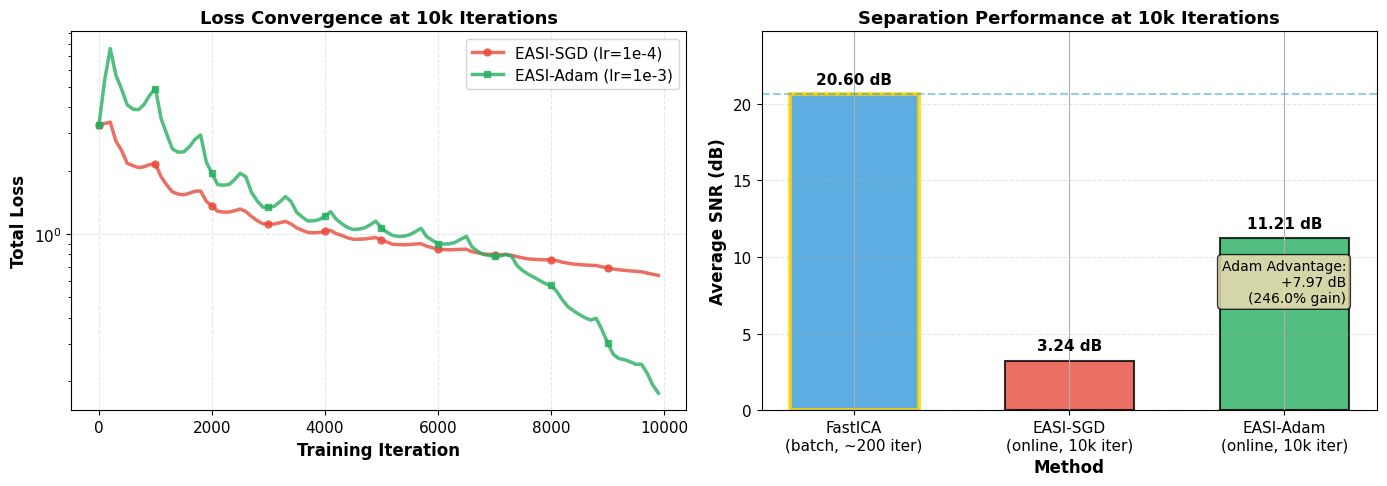

In [ ]:
# Extract loss data for 10k comparison
iters_sgd_10k = np.array([h['iteration'] for h in loss_history_sgd_10k])
loss_sgd_10k = np.array([h['total_loss'] for h in loss_history_sgd_10k])

iters_adam_10k = np.array([h['iteration'] for h in loss_history_adam_10k])
loss_adam_10k = np.array([h['total_loss'] for h in loss_history_adam_10k])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Loss convergence
ax1.plot(iters_sgd_10k, loss_sgd_10k, 'o-', color=color_sgd, linewidth=2.5,
         markersize=5, markevery=10, label='EASI-SGD (lr=1e-4)', alpha=0.8)
ax1.plot(iters_adam_10k, loss_adam_10k, 's-', color=color_adam, linewidth=2.5,
         markersize=5, markevery=10, label='EASI-Adam (lr=1e-3)', alpha=0.8)

ax1.set_xlabel('Training Iteration', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Loss', fontsize=12, fontweight='bold')
ax1.set_title('Loss Convergence at 10k Iterations', fontsize=13, fontweight='bold')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(loc='upper right', fontsize=11)

# Right: SNR comparison bar chart
methods = ['FastICA\n(batch, ~200 iter)', 'EASI-SGD\n(online, 10k iter)', 'EASI-Adam\n(online, 10k iter)']
snr_values = [avg_ica_10k, avg_sgd_10k, avg_adam_10k]
colors_bars = [color_ica, color_sgd, color_adam]

bars = ax2.bar(methods, snr_values, width=0.6, color=colors_bars,
               edgecolor='black', linewidth=1.5, alpha=0.8)

# Add value labels
for bar, val in zip(bars, snr_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{val:.2f} dB', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Highlight best method
max_idx = np.argmax(snr_values)
bars[max_idx].set_edgecolor('gold')
bars[max_idx].set_linewidth(3)

ax2.set_ylabel('Average SNR (dB)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Method', fontsize=12, fontweight='bold')
ax2.set_title('Separation Performance at 10k Iterations', fontsize=13, fontweight='bold')
ax2.grid(True, axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim([0, max(snr_values) * 1.2])

# Add FastICA baseline reference line
ax2.axhline(y=avg_ica_10k, color=color_ica, linestyle='--', linewidth=1.5, alpha=0.5)

# Add improvement annotation
improvement = avg_adam_10k - avg_sgd_10k
textstr = f'Adam Advantage:\n+{improvement:.2f} dB\n({(improvement/avg_sgd_10k)*100:.1f}% gain)'
ax2.text(0.95, 0.40, textstr, transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black'))

plt.tight_layout()
plt.show()

In [ ]:
# Summary table for 10k iteration comparison.
print(f"\n{'Method':<25} {'S1 SNR (dB)':<15} {'S2 SNR (dB)':<15} {'Avg SNR (dB)':<15}")
print("-" * 70)
print(f"{'FastICA (batch)':<25} {SNR1_ica_10k:<15.2f} {SNR2_ica_10k:<15.2f} {avg_ica_10k:<15.2f}")
print(f"{'EASI-SGD (online)':<25} {SNR1_sgd_10k:<15.2f} {SNR2_sgd_10k:<15.2f} {avg_sgd_10k:<15.2f}")
print(f"{'EASI-Adam (online)':<25} {SNR1_adam_10k:<15.2f} {SNR2_adam_10k:<15.2f} {avg_adam_10k:<15.2f}")
print("=" * 70)


Method                    S1 SNR (dB)     S2 SNR (dB)     Avg SNR (dB)   
----------------------------------------------------------------------
FastICA (batch)           11.86           29.33           20.60          
EASI-SGD (online)         1.99            4.49            3.24           
EASI-Adam (online)        10.10           12.31           11.21          


### 6.3 PDF Similarity Analysis.

We compare the probability distributions of original and recovered sources using KL divergence.

PDF Similarity Analysis (Lower KL divergence = better match)

Source 1 Analysis (EASI-Adam):


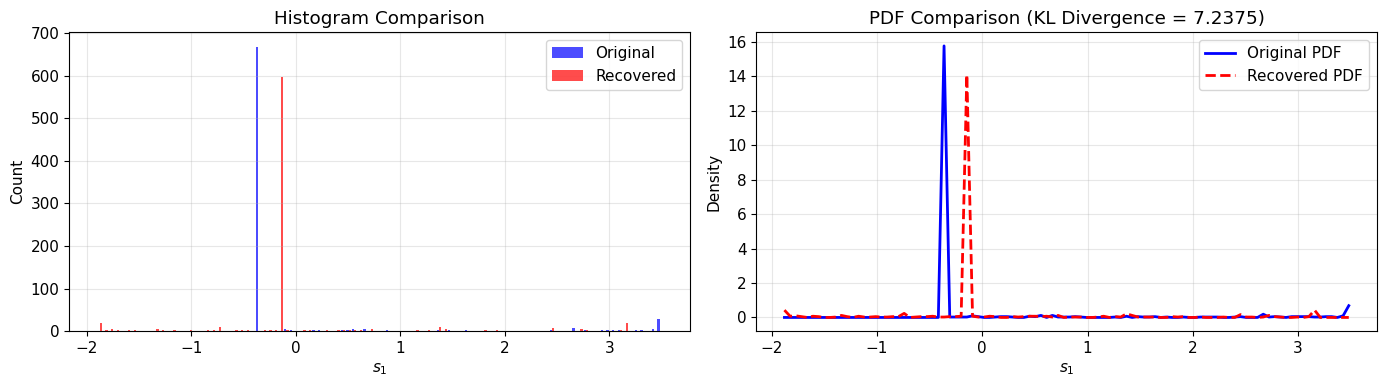

KL divergence: 7.2375

Source 2 Analysis (EASI-Adam):


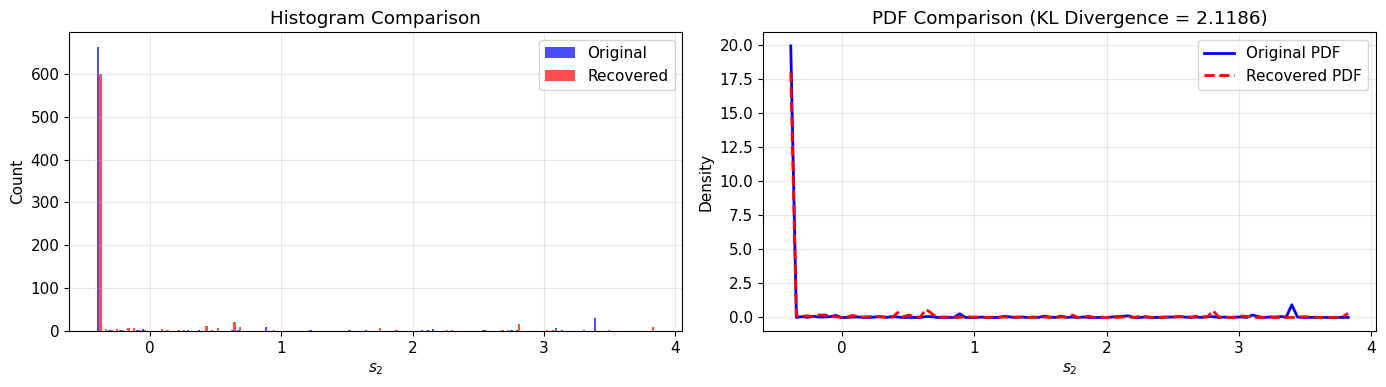

KL divergence: 2.1186


In [ ]:
print("=" * 60)
print("PDF Similarity Analysis (Lower KL divergence = better match)")
print("=" * 60)

# Compare source 1.
print("\nSource 1 Analysis (EASI-Adam):")
kl1_adam = plot_pdf_comparison(s1, y1_aligned_adam, num_bins=100, title_prefix="$s_1$")
print(f"KL divergence: {kl1_adam:.4f}")

# Compare source 2
print("\nSource 2 Analysis (EASI-Adam):")
kl2_adam = plot_pdf_comparison(s2, y2_aligned_adam, num_bins=100, title_prefix="$s_2$")
print(f"KL divergence: {kl2_adam:.4f}")

### 6.4 Independence Verification.

We verify that the recovered sources have restored statistical independence.

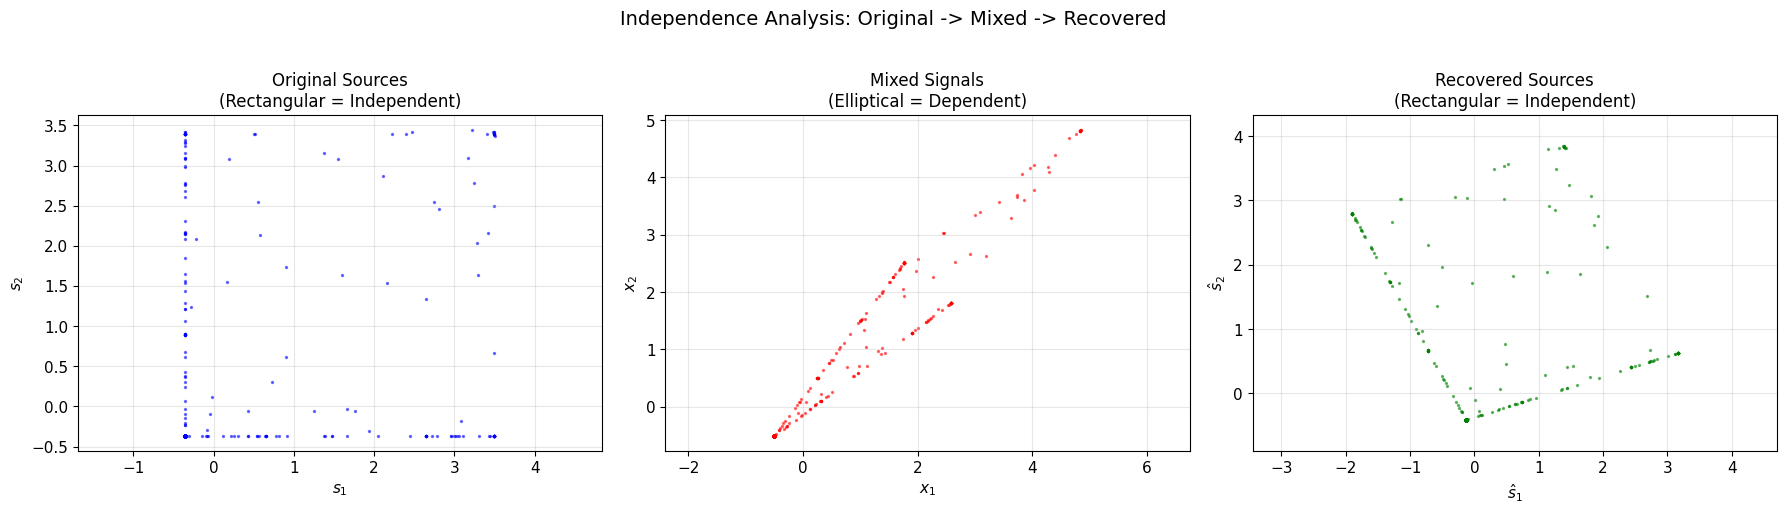

In [ ]:
# Compare independence: Original -> Mixed -> Recovered.
plot_scatter_comparison(s1, s2, x1, x2, y1_aligned_adam, y2_aligned_adam)